In [1]:
!pip install transformers datasets accelerate peft torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from datasets import Dataset

In [3]:
train_df = pd.read_csv("/content/x_fact_train_oversampled_9L.csv")
test_df = pd.read_csv("/content/x_fact_test_clean_9L.csv")

print("Train Data Sample:")
print(train_df.head())

print("\nTest Data Sample:")
print(test_df.head())

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])
test_df["label"] = label_encoder.transform(test_df["label"])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Mapping:", label_mapping)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["claim"].tolist(), train_df["label"].tolist(), test_size=0.1, random_state=42
)

test_texts = test_df["claim"].tolist()
test_labels = test_df["label"].tolist()

num_labels = len(set(train_labels))  # Number of unique labels
print(f"\nNumber of classes: {num_labels}")


Train Data Sample:
                                               claim         label
0  U nas mniej więcej połowa składów tramwajowych...         false
1  ...son on iki yılda TİKA yurt dışı ofis sayımı...   mostly true
2  Rusya kaynaklı nükleer sızıntı ve radyoaktif b...  mostly false
3  NASA vs Diyanet - 4: Kadının toplumsal rolüne ...          true
4  “Realizamos la mayor campaña de reclutamiento ...   mostly true

Test Data Sample:
                                               claim         label  \
0  Anton Hofreiter: „Wir können kriminelle Flücht...         false   
1  Skok (na Trybunał Konstytucyjny - przyp. Demag...  mostly false   
2  2017’de tarımsal kesime 12,7 milyar lira deste...          true   
3  Eşcinseller kan verme konusunda risk grubundad...         false   
4  წელს, 2015 წელთან შედარებით, საქართველოს აეროპ...          true   

  source_language  
0              de  
1              pl  
2              tr  
3              tr  
4              ka  

Label Mapping: {'f

In [4]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model = prepare_model_for_kbit_training(model)

# Define LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=128,  
    lora_alpha=256,
    lora_dropout=0.2
)

# Apply LoRA using PEFT
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()
print(model)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,312,260 || all params: 283,358,984 || trainable%: 1.8747


In [6]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    learning_rate=0.001,  
    gradient_accumulation_steps=4,  
    gradient_checkpointing=True, 
    logging_dir="./logs",
    logging_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),  # Weighted for multi-class
        "recall": recall_score(labels, predictions, average="weighted")  # Weighted recall
    }


In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: reyhaneh-ahani (reyhaneh-ahani-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.365700,1.363826,0.381984,0.297075,0.381984
2,1.304200,1.229181,0.449259,0.427329,0.449259
3,1.279100,1.208501,0.458381,0.443133,0.458381
4,1.276100,1.219927,0.467503,0.402874,0.467503
5,1.267300,1.256100,0.408210,0.369650,0.408210
6,1.261200,1.198714,0.451539,0.397517,0.451539
7,1.252600,1.205571,0.452680,0.380036,0.452680
8,1.249500,1.187908,0.481186,0.460091,0.481186
9,1.247800,1.188594,0.465222,0.450273,0.465222
10,1.249200,1.183353,0.467503,0.464371,0.467503


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

TrainOutput(global_step=7380, training_loss=1.239133893765085, metrics={'train_runtime': 7847.7356, 'train_samples_per_second': 30.15, 'train_steps_per_second': 0.94, 'total_flos': 6.585361823531827e+16, 'train_loss': 1.239133893765085, 'epoch': 29.88032454361055})

In [9]:
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)


Test Results: {'eval_loss': 1.2758451700210571, 'eval_accuracy': 0.3865069356872636, 'eval_f1': 0.3948942634781058, 'eval_recall': 0.3865069356872636, 'eval_runtime': 42.0664, 'eval_samples_per_second': 37.702, 'eval_steps_per_second': 4.731, 'epoch': 29.88032454361055}


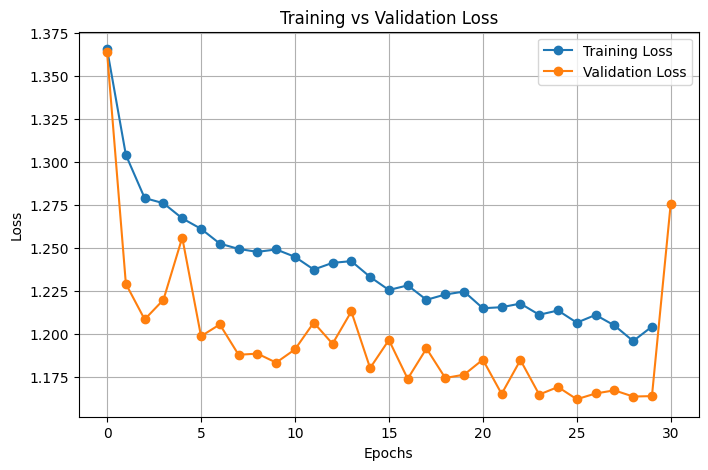

In [10]:
history = trainer.state.log_history

train_losses = [h["loss"] for h in history if "loss" in h]
val_losses = [h["eval_loss"] for h in history if "eval_loss" in h]

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()